In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA

In [12]:
class GaussianMixtureModel:
    def __init__(self, n_components, max_iter=100, tol=1e-6, reg_covar=1e-6):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg_covar = reg_covar

    def fit(self, X):
        n_samples, n_features = X.shape

        # Inicialización de parámetros
        self.weights = np.ones(self.n_components) / self.n_components
        rng = np.random.default_rng()
        indices = rng.choice(n_samples, self.n_components, replace=False)
        self.means = X[indices]
        self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])

        log_likelihood_old = -np.inf

        for iteration in range(self.max_iter):
            # Paso E: Calcular las responsabilidades
            responsibilities = self._expectation(X)

            # Guardar las medias anteriores para comparar la convergencia
            means_old = self.means.copy()

            # Paso M: Actualizar parámetros
            self._maximization(X, responsibilities)

            # Calcular la log-verosimilitud (evitando log(0))
            log_likelihood = np.sum(np.log(np.sum([
                self.weights[i] * multivariate_normal.pdf(
                    X, mean=self.means[i], cov=self.covariances[i]
                )
                for i in range(self.n_components)
            ], axis=0) + 1e-10))

            # Verificar convergencia (puedes usar la diferencia en las medias o en la log-verosimilitud)
            if np.linalg.norm(self.means - means_old) < self.tol or np.abs(log_likelihood - log_likelihood_old) < self.tol:
                break

            log_likelihood_old = log_likelihood

    def _expectation(self, X):
        n_samples, n_features = X.shape
        likelihood = np.zeros((n_samples, self.n_components))
        for i in range(self.n_components):
            likelihood[:, i] = self.weights[i] * multivariate_normal.pdf(
                X, mean=self.means[i], cov=self.covariances[i] + self.reg_covar * np.eye(n_features)
            )
        responsibilities = likelihood / (likelihood.sum(axis=1, keepdims=True) + 1e-10)
        return responsibilities

    def _maximization(self, X, responsibilities):
        n_samples, n_features = X.shape
        for i in range(self.n_components):
            resp = responsibilities[:, i]
            total_resp = resp.sum()
            self.weights[i] = total_resp / n_samples
            self.means[i] = (X * resp[:, np.newaxis]).sum(axis=0) / total_resp

            # Cálculo manual de la covarianza
            diff = X - self.means[i]
            self.covariances[i] = np.dot((resp[:, np.newaxis] * diff).T, diff) / total_resp
            # Agregar regularización para evitar singularidad
            self.covariances[i] += self.reg_covar * np.eye(n_features)

    def bic(self, X):
        n_samples, n_features = X.shape
        n_params = self.n_components * (1 + n_features + n_features * (n_features + 1) / 2) - 1
        log_likelihood = np.sum(np.log(np.sum([
            self.weights[i] * multivariate_normal.pdf(
                X, mean=self.means[i], cov=self.covariances[i]
            )
            for i in range(self.n_components)
        ], axis=0) + 1e-10))
        return -2 * log_likelihood + n_params * np.log(n_samples)

    def log_likelihood(self, X):
        likelihood = np.zeros((X.shape[0], self.n_components))
        for i in range(self.n_components):
            likelihood[:, i] = self.weights[i] * multivariate_normal.pdf(X, self.means[i], self.covariances[i])
        
        # Evitar valores cero agregando un epsilon pequeño
        epsilon = 1e-10  # Un valor muy pequeño
        return np.sum(np.log(np.sum(likelihood, axis=1) + epsilon))

In [4]:
df = pd.read_csv('bank_transactions_cleaned.csv')

df_subset = df[['CustGender',
                'CustLocation',
                'CustAccountBalance',
                'TransactionTime',
                'TransactionAmount (INR)',
                'TransactionYear',
                'TransactionMonth',
                'TransactionDay',
                'TransactionWeekday']]

In [14]:
data = df_subset.to_numpy()

# 6. Aplicar PCA a todo el dataset
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

In [15]:
bic_scores = []
n_components_range = range(1, 11)
for n_components in n_components_range:
    gmm = GaussianMixtureModel(n_components=n_components)
    gmm.fit(data_pca)
    bic_scores.append(gmm.bic(data_pca))

In [13]:
gmm = GaussianMixtureModel(n_components=optimal_n_components)
gmm.fit(data_pca)

Log-Likelihood: -24038404.746088218


Text(0.5, 1.0, 'Segmentación de Clientes usando GMM y PCA')

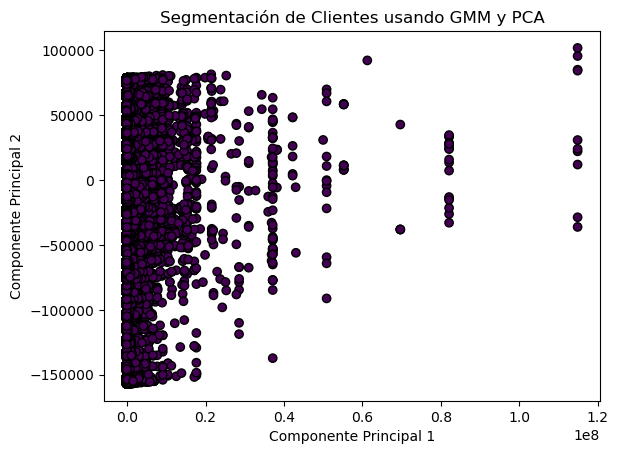

In [9]:
labels = np.argmax(gmm._expectation(data_pca), axis=1)

# 11. Visualizar los clusters
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis', edgecolor='k')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Segmentación de Clientes usando GMM y PCA')